<a href="https://colab.research.google.com/github/spiritofdragon/atrium-segmentation/blob/main/predictation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install celluloid
!pip install numpy
!pip install torch
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

In [ ]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)


class UNet(torch.nn.Module):
    """
    This class implements a UNet for the Segmentation
    We use 3 down- and 3 UpConvolutions and two Convolutions in each step
    """

    def __init__(self):
        """Sets up the U-Net Structure
        """
        super().__init__()


        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        #########################################

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):

        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################

        ####### DownConv 2#########
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################

        ##### Intermediate Layer ##
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)  # Upsample with a factor of 2
        #x5 = torch.nn.ConvTranspose2d(512, 512, 2, 2)(x4)
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        #x6 = torch.nn.ConvTranspose2d(256, 256, 2, 2)(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection
        x6 = self.layer6(x6)
        ###########################

        ####### UpCONV 3#########
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        #x7 = torch.nn.ConvTranspose2d(128, 128, 2, 2)(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        ###########################

        ####### Predicted segmentation#########
        ret = self.layer8(x7)
        return ret

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter) / denum
        return 1 - dice

In [ ]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Val Dice", loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    def log_images(self, mri, pred, mask, name):
        pred = pred > 0.5

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)

        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[1].imshow(mask_, alpha=0.6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
model = AtriumSegmentation.load_from_checkpoint("/content/drive/MyDrive/06-Atrium-Segmentation/logs/lightning_logs/version_5/checkpoints/epoch=70-step=17182.ckpt")

In [ ]:
subject = Path("/content/drive/MyDrive/06-Atrium-Segmentation/Task02_Heart/imagesTs/la_001.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [ ]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data

In [ ]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [ ]:
standardized_scan.shape

(336, 336, 180)

In [ ]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

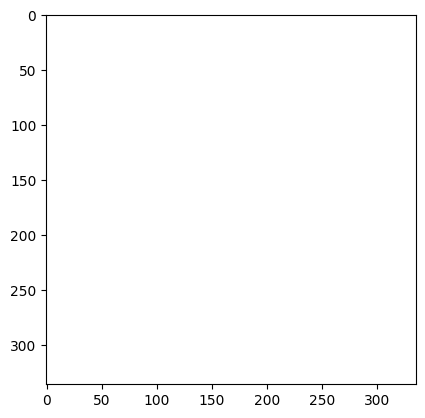

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")

    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())